In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from scipy.optimize import curve_fit

#import utils_v2 as u
module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)


#import include functions
module_name = "include"
file_path = "/workspaces/TP3/TP_Dying-cells/include.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)


# Importer les modules
import utils_v2 as u

import include as inc
from include import import_dataset
from include import MSD, auto_correlation_function
from include import mean_std_velocity

# Import datas

In [3]:
dir = "/workspaces/TP3/TP_Dying-cells/Datas/"
directories = ["2.5mM_0V_007", "2.5mM_5V_003", "2.5mM_10V_001", "2.5mM_15V_001","2.5mM_20V_001"]

data_lists = []
for directory in directories:
    print(f"Importing data from {directory}")
    datas_list = import_dataset(dir + directory+ "_spots.csv", dir + directory+ "_dt.csv")
    data_lists.append(datas_list)
    
#the frame where the pulse starts
Pulse_Frames = [0,85,98,102,121]

#time after the pulse for velocities
time_after = 2.4

#selected tracks to plot and vizualize
selected_tracks = [[0,1,3,4,5],[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]]

#time to convolve the data
convolve_time = 6


Importing data from 2.5mM_0V_007
Importing data from 2.5mM_5V_003
Importing data from 2.5mM_10V_001
Importing data from 2.5mM_15V_001
Importing data from 2.5mM_20V_001


## Plot all trajectories

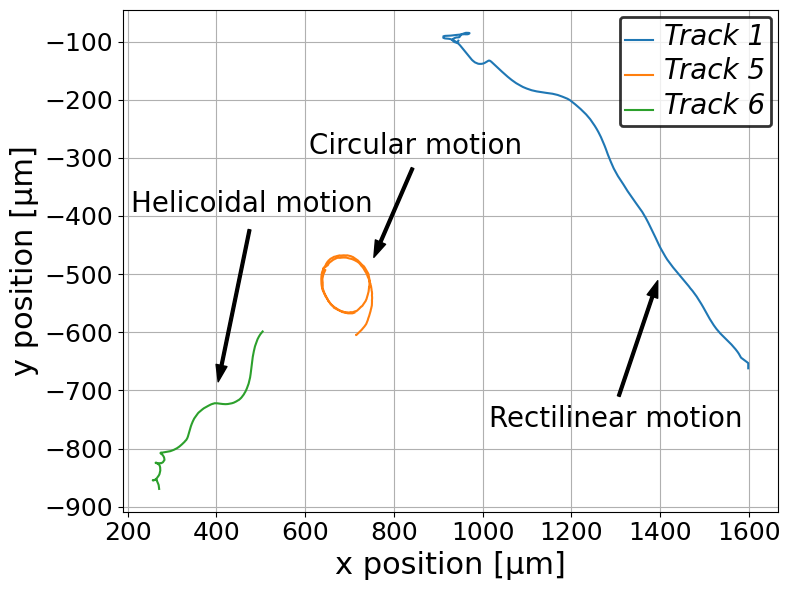

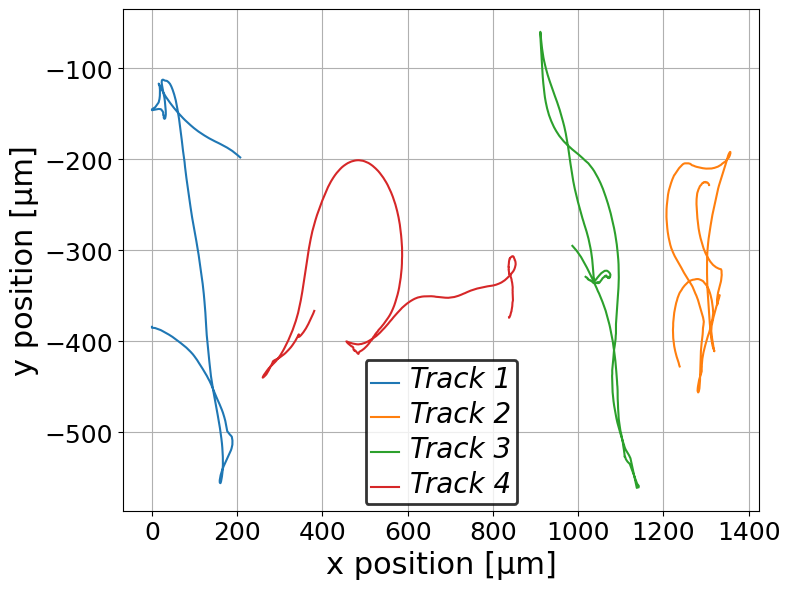

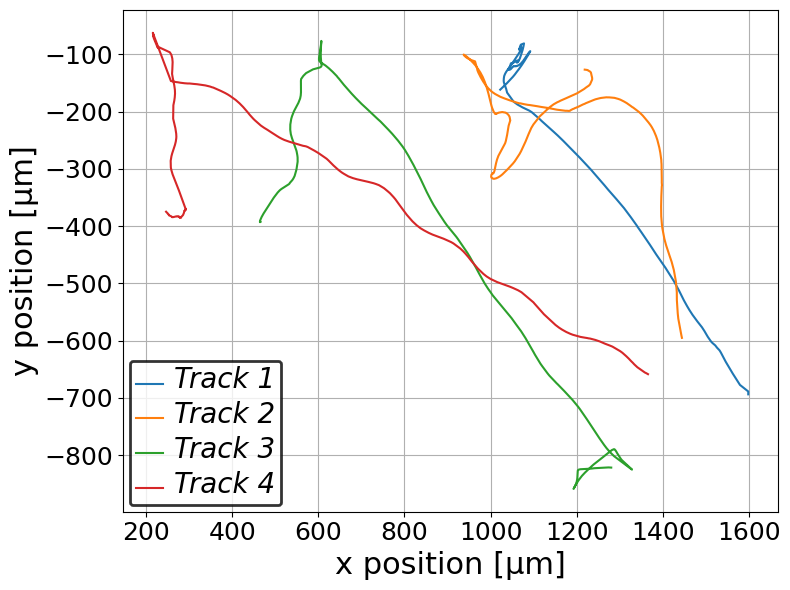

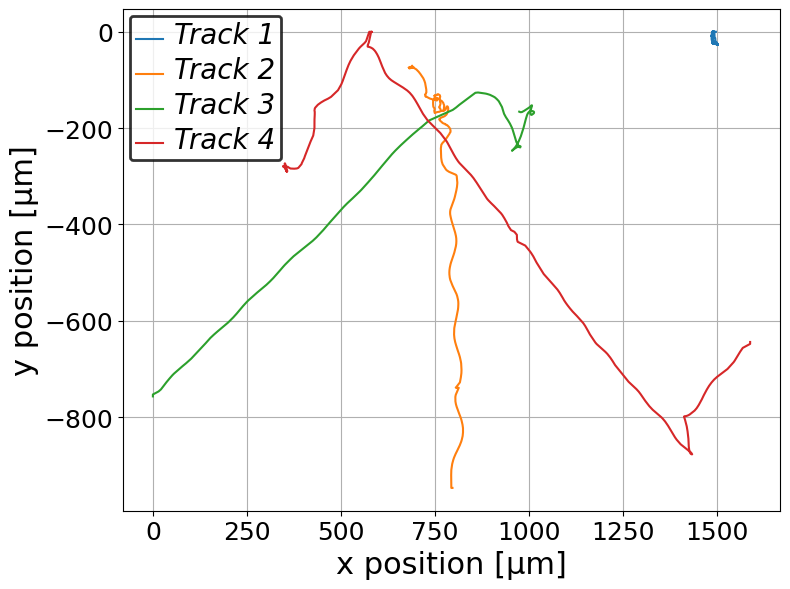

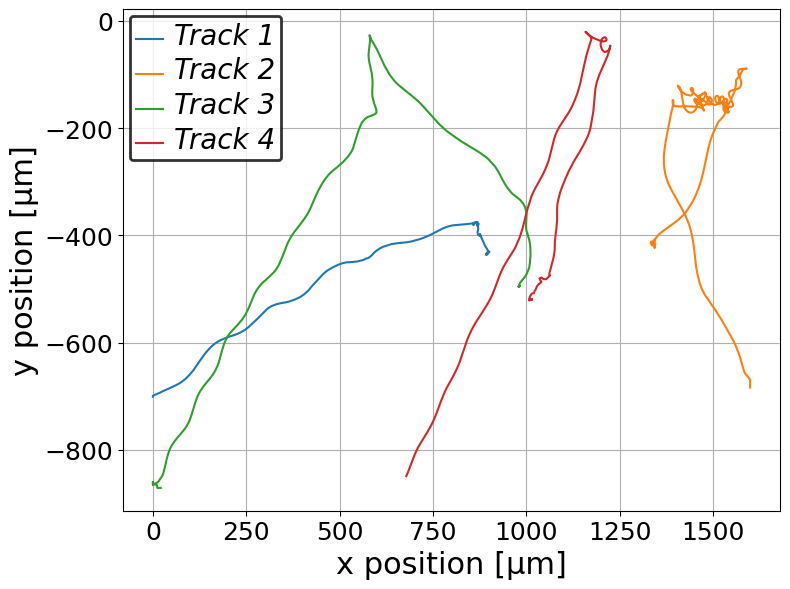

In [48]:
selected_tracks_traj = [[0,4,5],[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]]


xlabel = r"x position [µm]"  
ylabel = r"y position [µm]"

for i in range(len(data_lists)):
    data_list = data_lists[i]
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    
    for j in selected_tracks_traj[i]:
        
        x = data_list[j][1]
        y = data_list[j][2]
        t = data_list[j][0]
        
        ax.plot(x,-y, label=f"Track {j+1}")
        
    if i==0 : 
        #plot arrows and text at coords x = 0.5 and y = -0.5 using the ax.annotate method
        ax.annotate(f"Circular motion", xy=(750, -480), xytext=(850, -280), 
                    arrowprops=dict(facecolor='black', shrink=0.05,
                                    width=2, headwidth=8),
                    fontsize=20, color='black', ha='center', va='center')
        
        ax.annotate(f"Helicoidal motion", xy=(400, -700), xytext=(480, -380), 
                    arrowprops=dict(facecolor='black', shrink=0.05,
                                    width=2, headwidth=8),
                    fontsize=20, color='black', ha='center', va='center')
        
        ax.annotate(f"Rectilinear motion", xy=(1400, -500), xytext=(1300, -750), 
                    arrowprops=dict(facecolor='black', shrink=0.05,
                                    width=2, headwidth=8),
                    fontsize=20, color='black', ha='center', va='center')
        
        fig.savefig("/workspaces/TP3/TP_Dying-cells/Figures/" + directories[i] + "_trajectories.pdf", bbox_inches='tight')

        
        
    u.set_legend_properties(ax)
    plt.show()

    

## Plot position-time

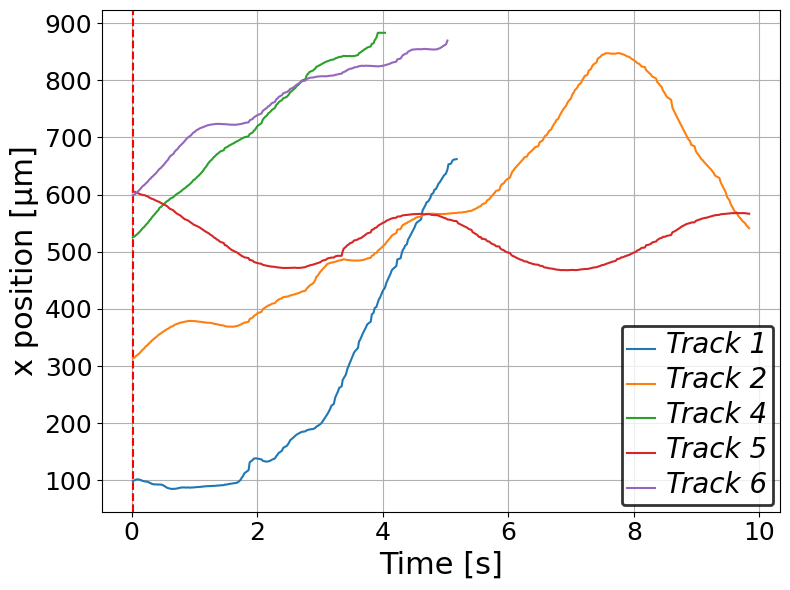

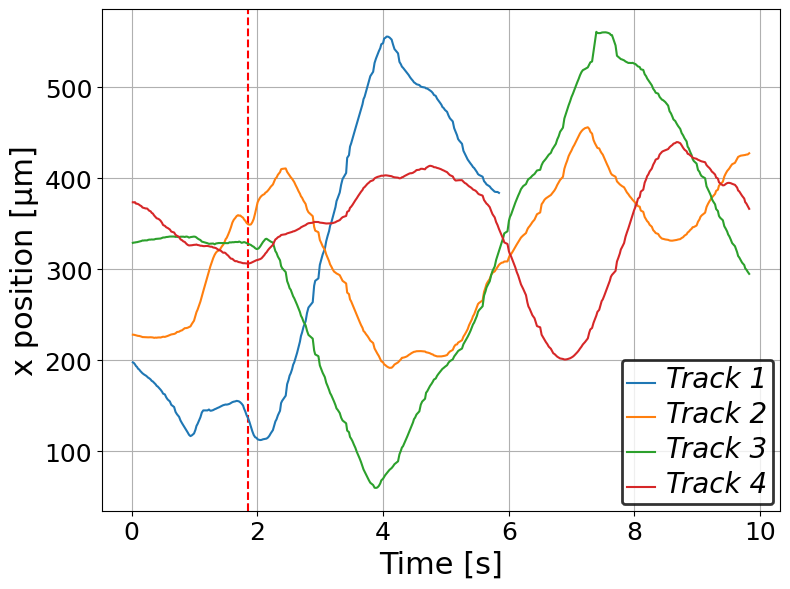

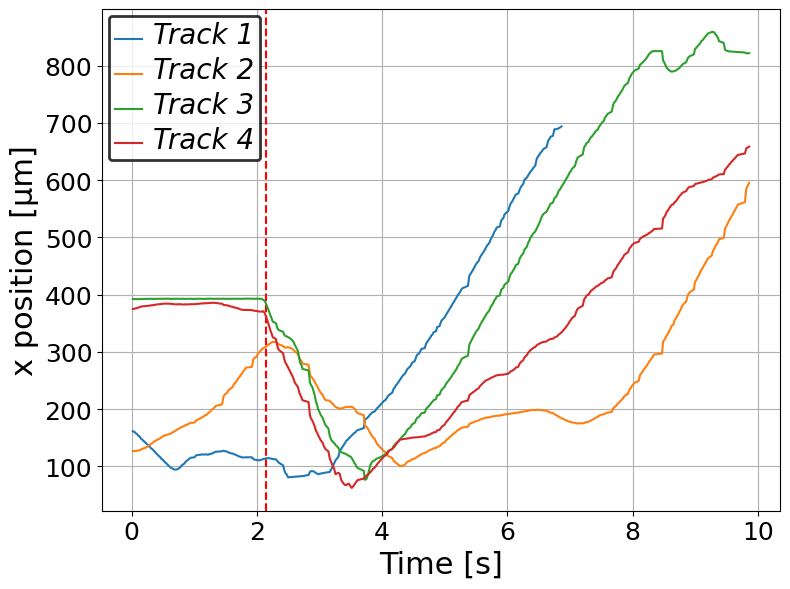

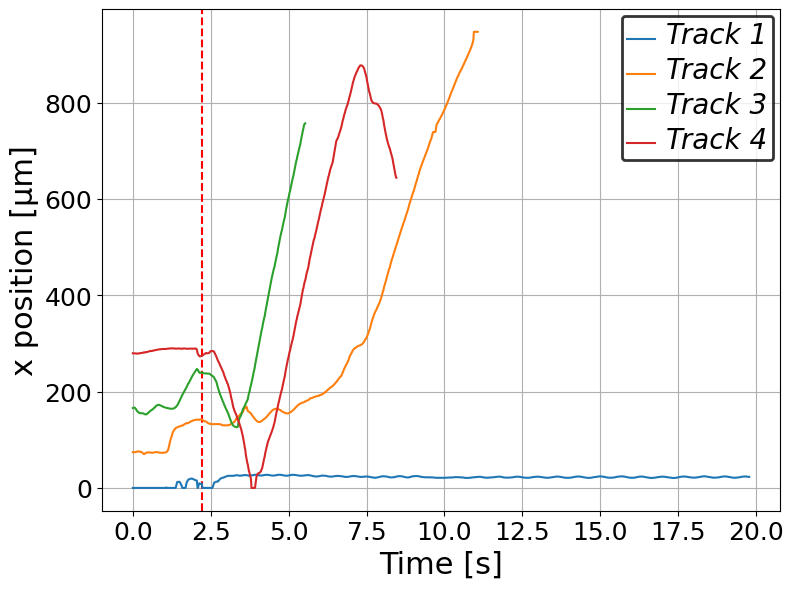

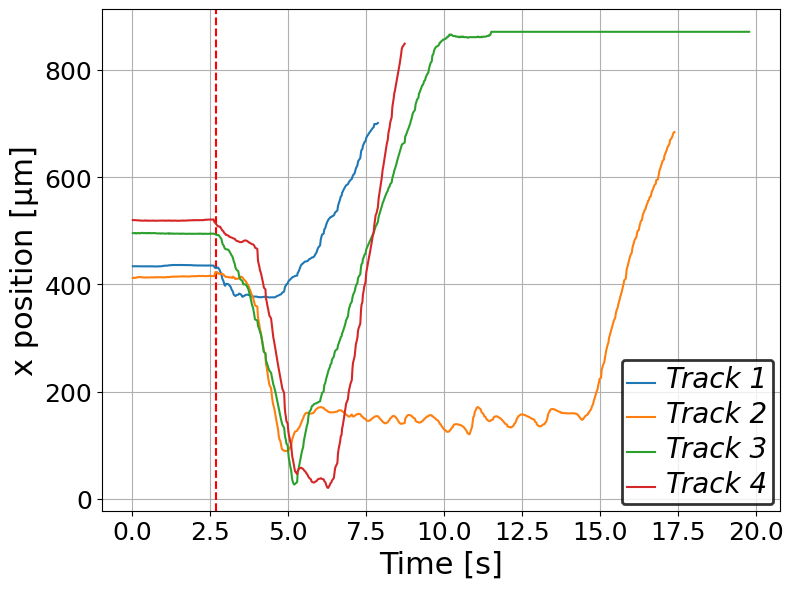

In [5]:
xlabel = r"Time [s]"
ylabel = r"x position [µm]"

for i in range(len(data_lists)):
    data_list = data_lists[i]
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    
    frame = Pulse_Frames[i]
    
    t = data_list[0][0]
    t_pulse = t[frame]
    
    ax.axvline(t_pulse, color='red', linestyle='--')
    
    for j in selected_tracks[i]:
        
        x = data_list[j][1]
        y = data_list[j][2]
        t = data_list[j][0]
        
        ax.plot(t,y, label=f"Track {j+1}")
        
    u.set_legend_properties(ax)
    # ax.set_xlim(0,0.1)
    # ax.set_ylim(245,280)
    plt.show()



## Plot velocity-time


Voltage 0, Track 1
Voltage 0, Track 2
Voltage 0, Track 4
Voltage 0, Track 5
Voltage 0, Track 6


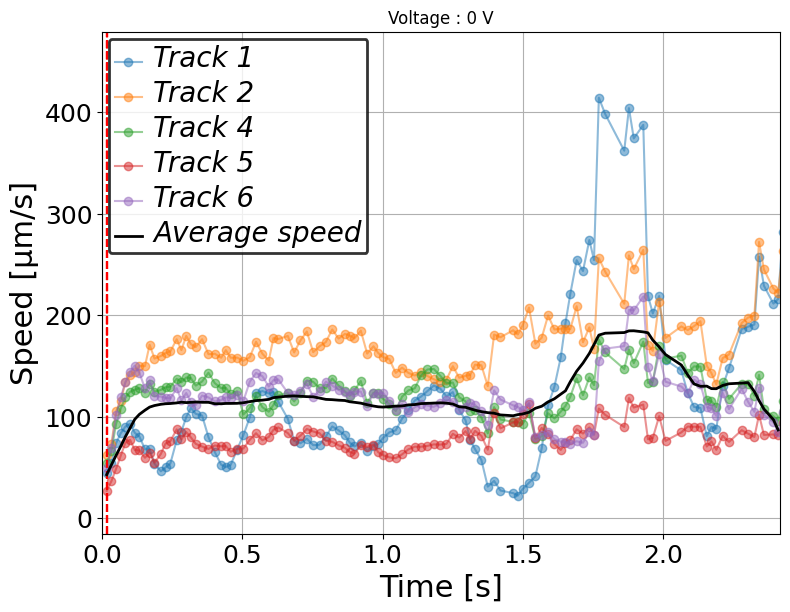

Voltage 1, Track 1
Voltage 1, Track 2
Voltage 1, Track 3
Voltage 1, Track 4


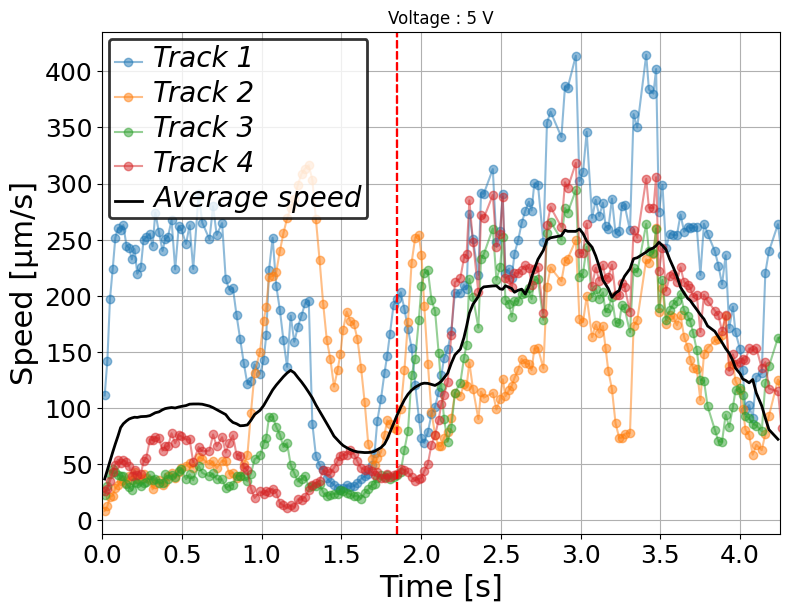

Voltage 2, Track 1
Voltage 2, Track 2
Voltage 2, Track 3
Voltage 2, Track 4


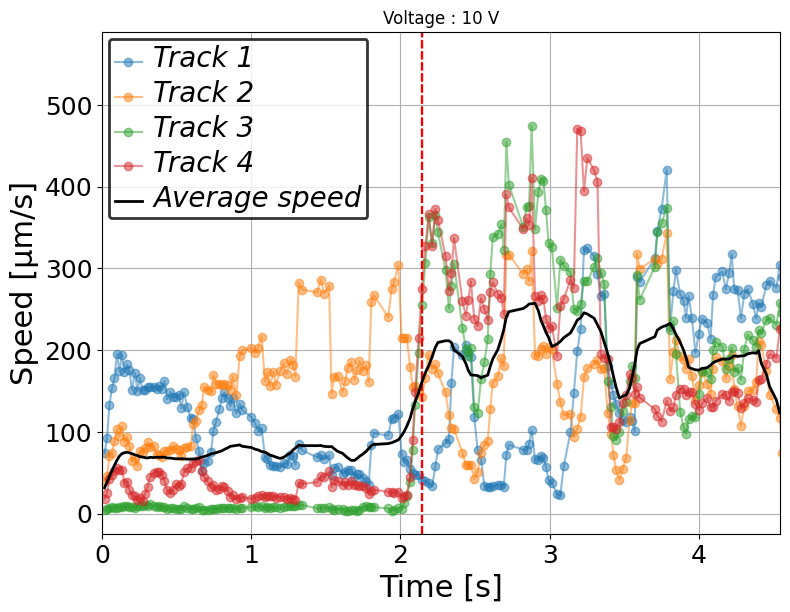

Voltage 3, Track 1
Voltage 3, Track 2
Voltage 3, Track 3
Voltage 3, Track 4


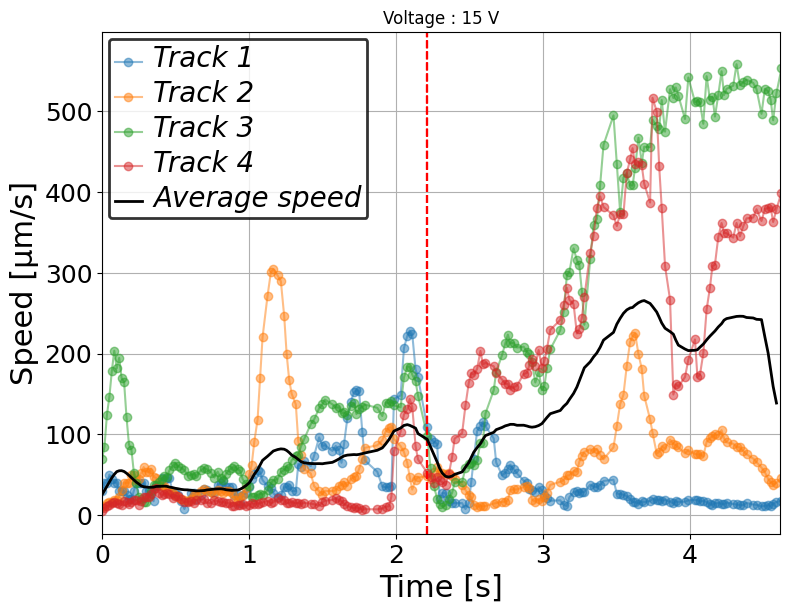

Voltage 4, Track 1
Voltage 4, Track 2
Voltage 4, Track 3
Voltage 4, Track 4


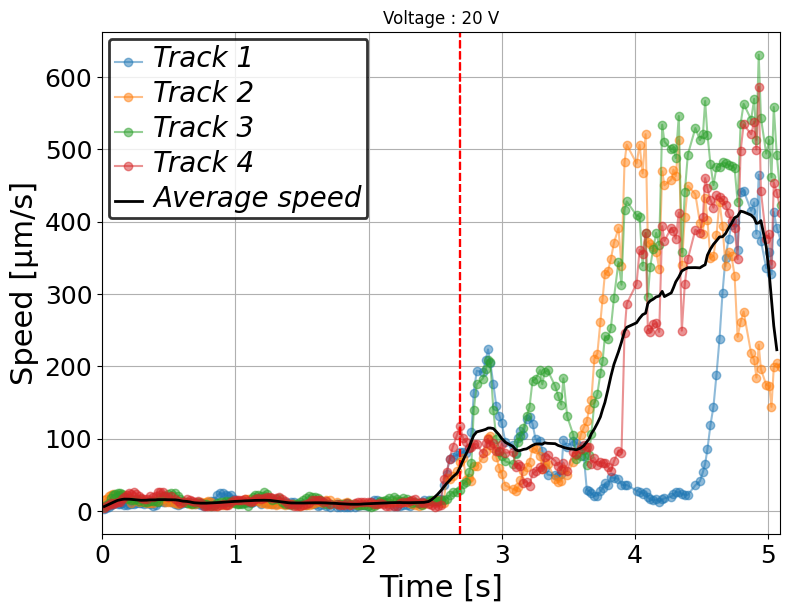

In [6]:
Vs = [0,5,10,15,20]

for i in range(len(data_lists)):
    data_list = data_lists[i]
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel="Time [s]", ylabel="Speed [µm/s]")
    
    frame = Pulse_Frames[i]
    t = data_list[0][0]
    t_pulse = t[frame]
    
    if selected_tracks[i] == []:
        selected_tracks[i] = list(range(len(data_list)))
    
    avg_tracks_speed = 0
    
    for j in selected_tracks[i]:
        # Calculate the speed of the track
        x = data_list[j][1]
        y = data_list[j][2]
        t = data_list[j][0]

        dx = np.diff(x)
        dy = np.diff(y)
        dt = np.diff(t)

        speed = np.sqrt(dx**2 + dy**2) / dt
        
        speed = np.convolve(speed, np.ones(convolve_time)/convolve_time, mode='same')

        #select the speeds we want
        mask = t[:-1] <= t_pulse + time_after
        speed_avg = speed[mask]
        t_avg = t[:-1][mask]
        
        speed_avg = np.convolve(speed_avg, np.ones(2*convolve_time)/(2*convolve_time), mode='same')
         # Adjust time array to match convolved speed length
        
        print(f"Voltage {i}, Track {j+1}")
                
        avg_tracks_speed += speed_avg        
        ax.plot(t[:-1], speed, marker='o', linestyle='-', label=f"Track {j+1}",alpha=0.5)
        ax.axvline(t_pulse, color='red', linestyle='--')
        
        
    avg_tracks_speed /= len(selected_tracks[i])
    
    ax.plot(t_avg, avg_tracks_speed, color='black', linewidth=2, label="Average speed")
    
    u.set_legend_properties(ax)
    
    ax.set_xlim(0,t_pulse +time_after)
    # ax.set_xlim(0,2)
    
    ax.set_title(f"Voltage : {Vs[i]} V")

    fig.savefig("/workspaces/TP3/TP_Dying-cells/Figures/" + directories[i] + "_velocity_time.pdf", bbox_inches='tight')
    plt.show()

## Compute mean speed and std for each track, for each V

Dataset 1: Pulse at frame 0, time 0.02 seconds
Dataset 2: Pulse at frame 85, time 1.85 seconds
Dataset 3: Pulse at frame 98, time 2.14 seconds
Dataset 4: Pulse at frame 102, time 2.21 seconds
Dataset 5: Pulse at frame 121, time 2.69 seconds


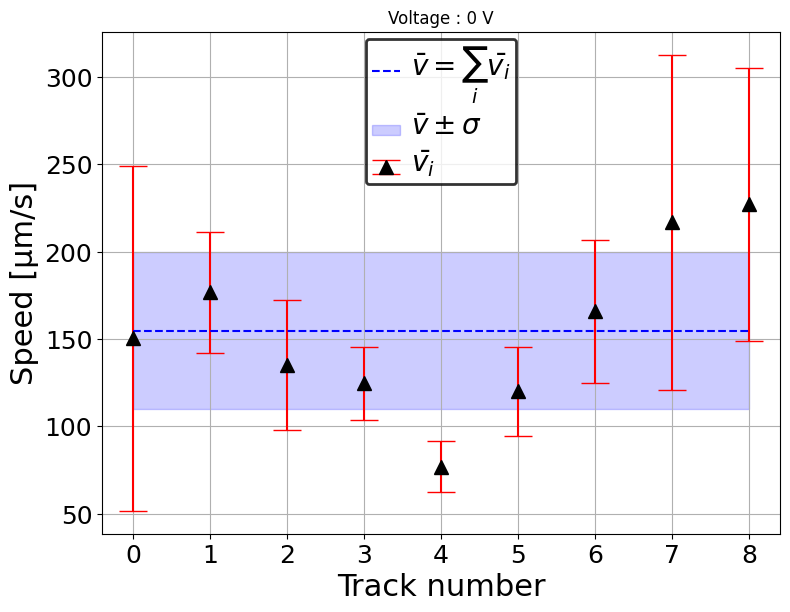

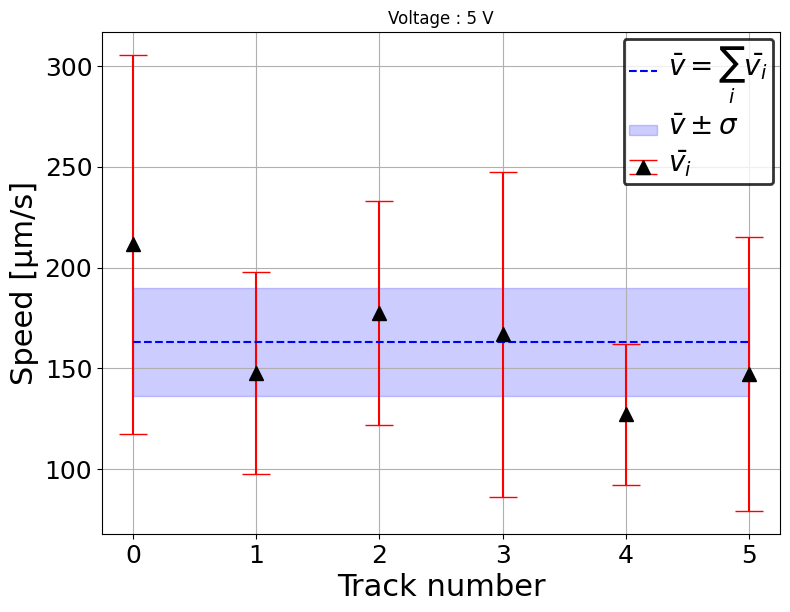

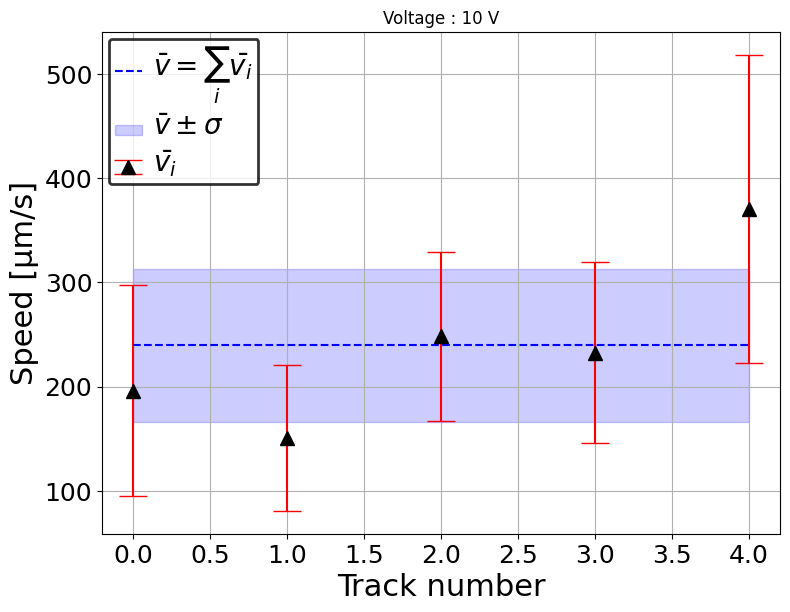

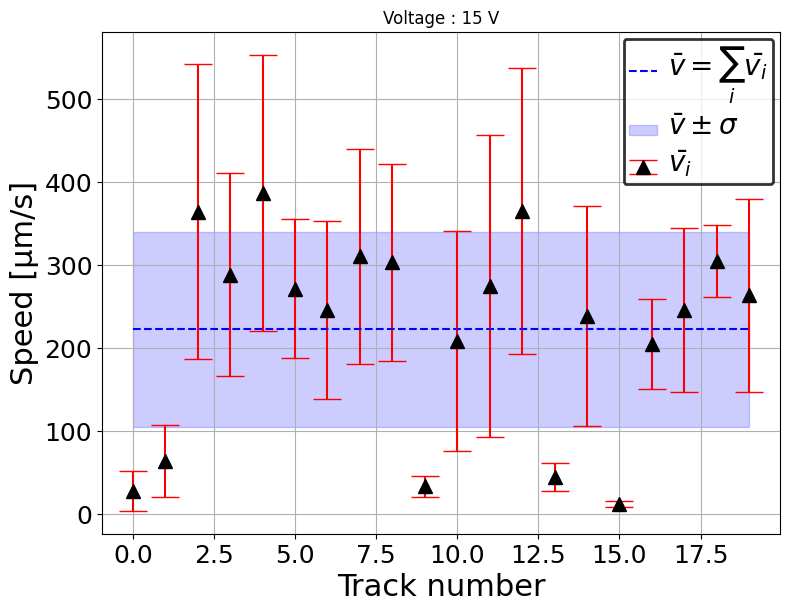

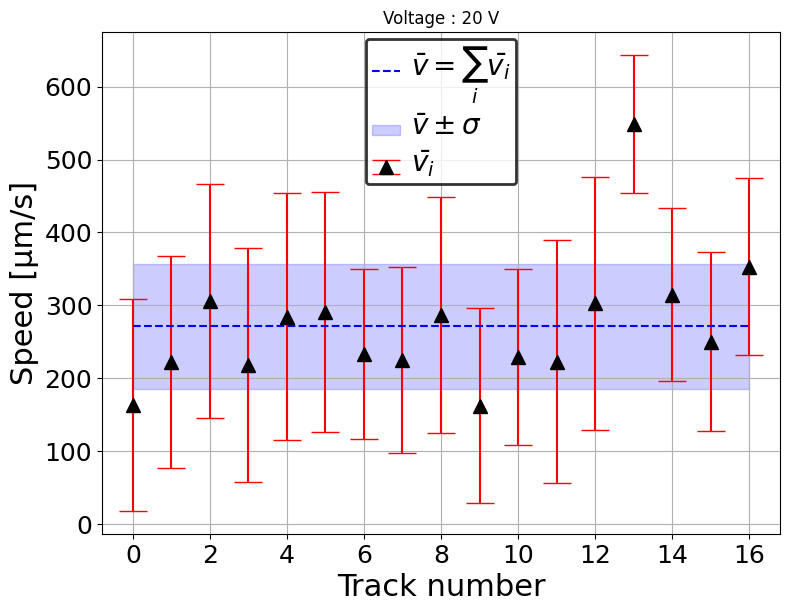

In [50]:
time_after_pulse =  3

avg_speeds,std_speeds = mean_std_velocity(data_lists,Pulse_Frames,time_after_pulse,convolve_time) 

total_avg_speeds = []
total_std_speeds = []

Vs = [0,5,10,15, 20]

for i in range(len(data_lists)):
    
    avg_speeds_i = avg_speeds[i]
    std_speeds_i = std_speeds[i]
    
    # Calculate the mean of all mean speeds
    mean_avg_speed = np.mean(avg_speeds_i)
    std_mean_avg_speed = np.std(avg_speeds_i)

    total_avg_speeds.append(mean_avg_speed)
    total_std_speeds.append(std_mean_avg_speed)
        
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel="Track number", ylabel="Speed [µm/s]")

    # Plot the average speed of each track
    ax.errorbar(range(len(avg_speeds_i)), avg_speeds_i, yerr=std_speeds_i, markersize=10, capsize=10, capthick=1, fmt='^', label=r'$\bar{v_i}$',ecolor='red', color='black')

    ax.hlines(mean_avg_speed, 0, len(avg_speeds_i)-1, color='blue', linestyle='--', label=r'$\bar{v}=\sum_i{\bar{v_i}}$')

    ax.fill_between(range(len(avg_speeds_i)), mean_avg_speed-std_mean_avg_speed, mean_avg_speed+std_mean_avg_speed, color='blue', alpha=0.2,label=r'$\bar{v} \pm \sigma$')
    
    u.set_legend_properties(ax)

    ax.set_title(f"Voltage : {Vs[i]} V")
    
    fig.savefig("/workspaces/TP3/TP_Dying-cells/Figures/" + directories[i] + "_velocity.pdf", bbox_inches='tight')
    plt.show()


## Plot total mean speed and std for Vs 

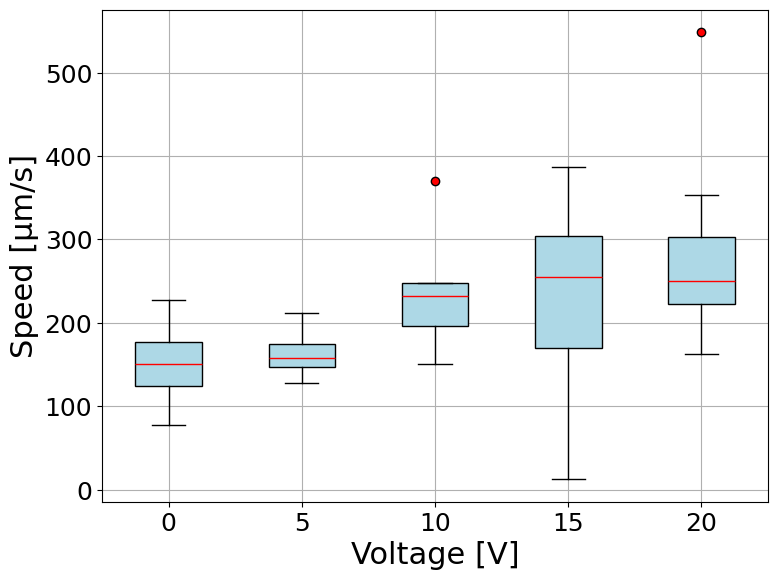

In [51]:
total_avg_speeds = np.array(total_avg_speeds)
total_std_speeds = np.array(total_std_speeds)

xlabel = "Voltage [V]"
ylabel = "Speed [µm/s]"

Vs = [0,5,10,15, 20]

ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
# ax.errorbar(Vs, total_avg_speeds, yerr=total_std_speeds, markersize=10, capsize=10, capthick=1, fmt='^', label=r'$\bar{v} = \sum_i{\bar{v_i}}$',ecolor='red', color='black')
ax.boxplot(avg_speeds,tick_labels=Vs, notch=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'), medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'), flierprops=dict(markerfacecolor='red', markeredgecolor='black'))

# u.set_legend_properties(ax)
plt.show()
fig.savefig("/workspaces/TP3/TP_Dying-cells/Figures/2.5mM_velocity_vs_voltage.pdf", bbox_inches='tight')

## Autocorrelation function


/workspaces/TP3/TP_Dying-cells/include.py:303: RuntimeWarning: invalid value encountered in divide
  vx /= norm
/workspaces/TP3/TP_Dying-cells/include.py:304: RuntimeWarning: invalid value encountered in divide
  vy /= norm


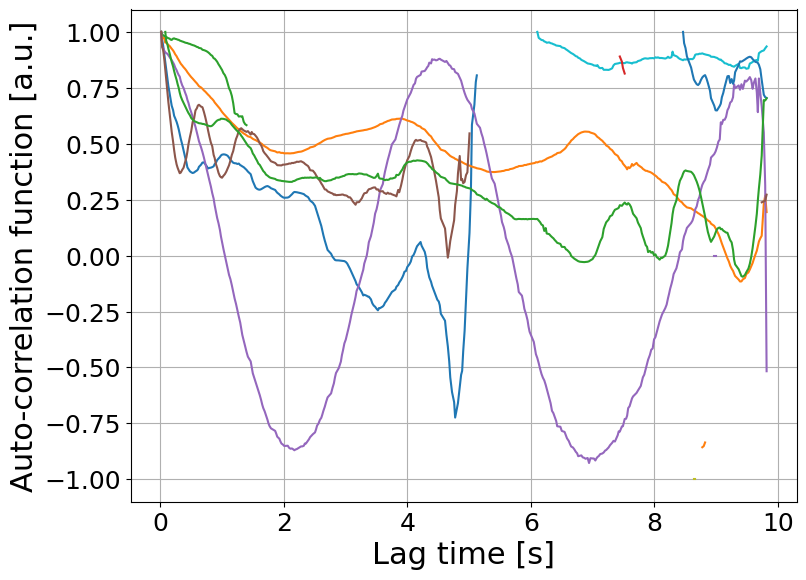

/workspaces/TP3/TP_Dying-cells/include.py:303: RuntimeWarning: invalid value encountered in divide
  vx /= norm
/workspaces/TP3/TP_Dying-cells/include.py:304: RuntimeWarning: invalid value encountered in divide
  vy /= norm


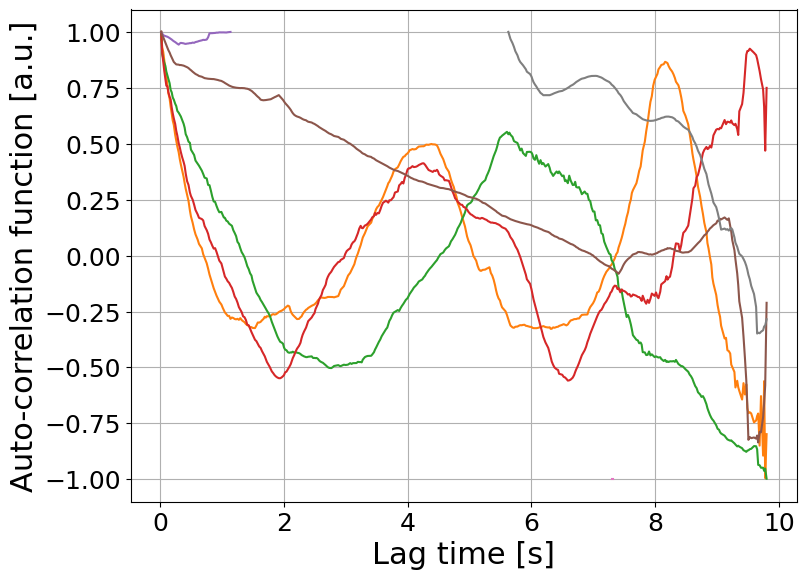

/workspaces/TP3/TP_Dying-cells/include.py:303: RuntimeWarning: invalid value encountered in divide
  vx /= norm
/workspaces/TP3/TP_Dying-cells/include.py:304: RuntimeWarning: invalid value encountered in divide
  vy /= norm


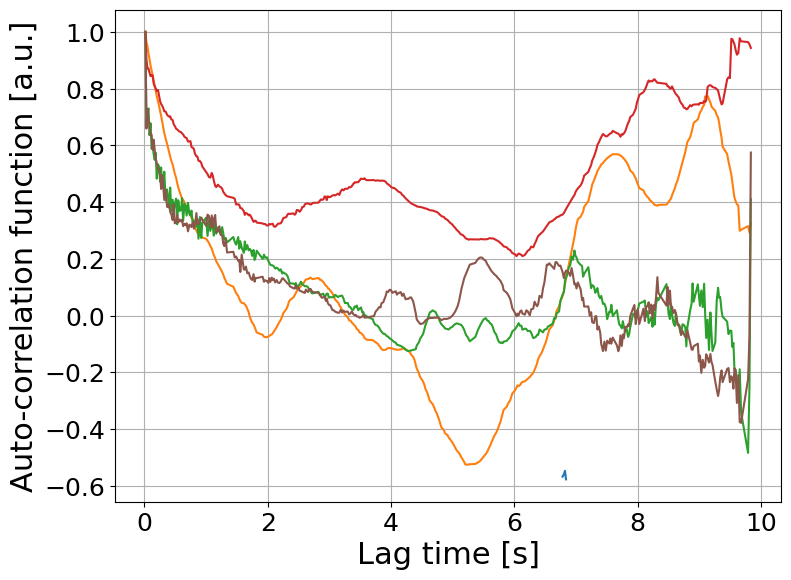

/workspaces/TP3/TP_Dying-cells/include.py:303: RuntimeWarning: invalid value encountered in divide
  vx /= norm
/workspaces/TP3/TP_Dying-cells/include.py:304: RuntimeWarning: invalid value encountered in divide
  vy /= norm


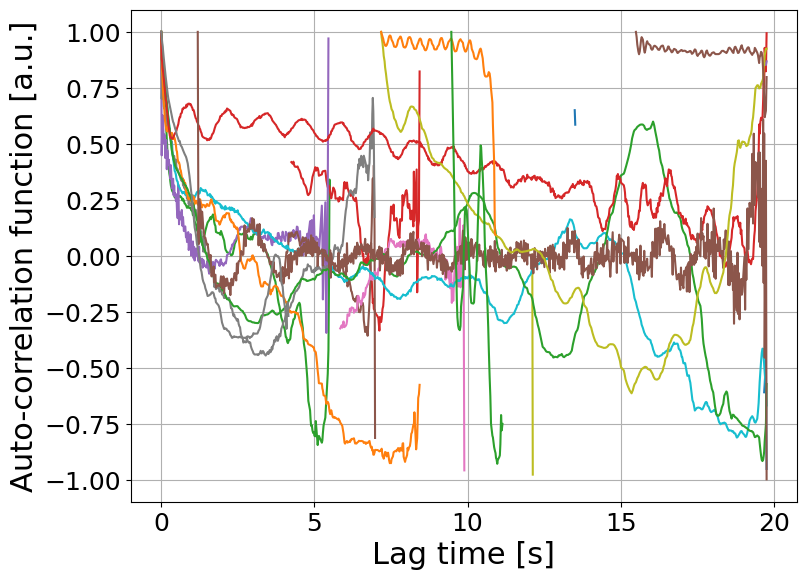

/workspaces/TP3/TP_Dying-cells/include.py:303: RuntimeWarning: invalid value encountered in divide
  vx /= norm
/workspaces/TP3/TP_Dying-cells/include.py:304: RuntimeWarning: invalid value encountered in divide
  vy /= norm


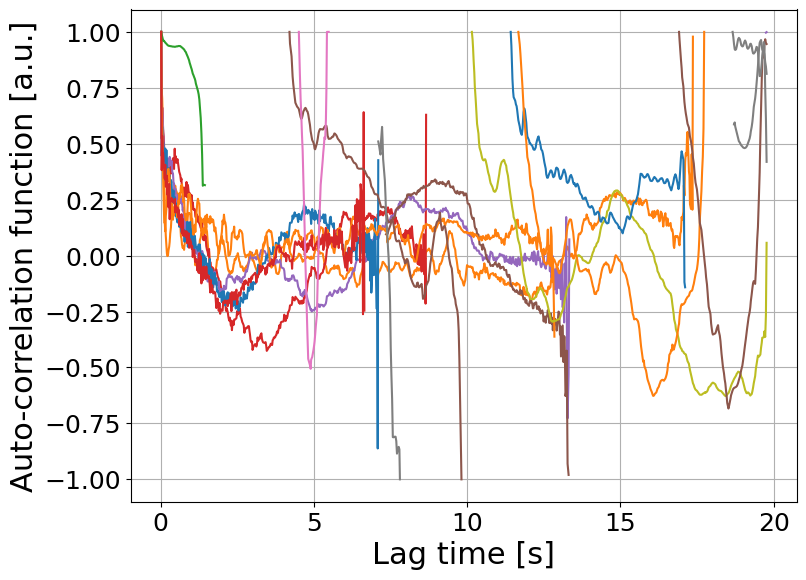

In [9]:
xlabel = r"Lag time [s]"
ylabel = r"Auto-correlation function [a.u.]"

for i in range(len(data_lists)):
    data_list = data_lists[i]
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    
    for j in range(len(data_list)):
        # Calculate the speed of the track
        x = data_list[j][1]
        y = data_list[j][2]
        t = data_list[j][0]

        dx = np.diff(x)
        dy = np.diff(y)
        dt = np.diff(t)
        
        v_x = dx / dt
        v_y = dy / dt
        
        max_lag = len(v_x)-1
        
        # Calculate the auto-correlation function
        acf = auto_correlation_function(v_x,v_y,max_lag,normalize=True)
    
        ax.plot(t[:-1],acf, label=f"Track {j+1}")
        
    # u.set_legend_properties(ax)
    fig.savefig("/workspaces/TP3/TP_Dying-cells/Figures/" + directories[i] + "_acf.pdf", bbox_inches='tight')
    plt.show()
        
        
        
        

Track 3 for voltage 0 has less than 2 points after the pulse, skipping.
Track 9 for voltage 0 has less than 2 points after the pulse, skipping.
Track 10 for voltage 0 has less than 2 points after the pulse, skipping.
Track 11 for voltage 0 has less than 2 points after the pulse, skipping.
Track 16 for voltage 0 has less than 2 points after the pulse, skipping.


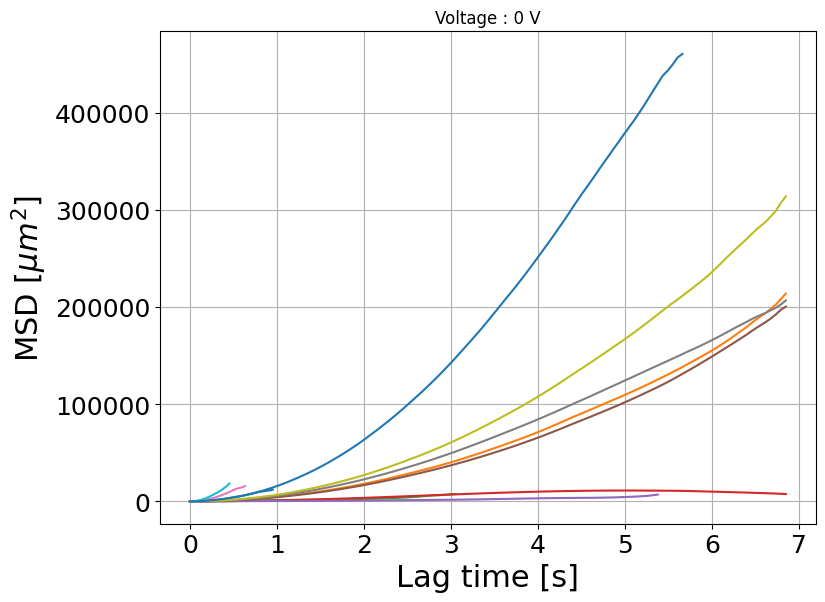

Track 5 for voltage 1 has less than 2 points after the pulse, skipping.
Track 8 for voltage 1 has less than 2 points after the pulse, skipping.
Track 9 for voltage 1 has less than 2 points after the pulse, skipping.


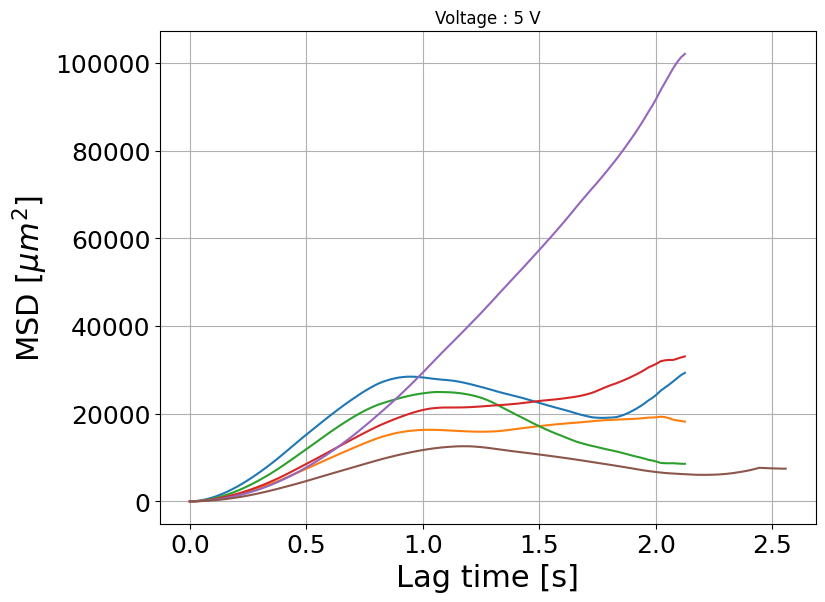

Track 5 for voltage 2 has less than 2 points after the pulse, skipping.


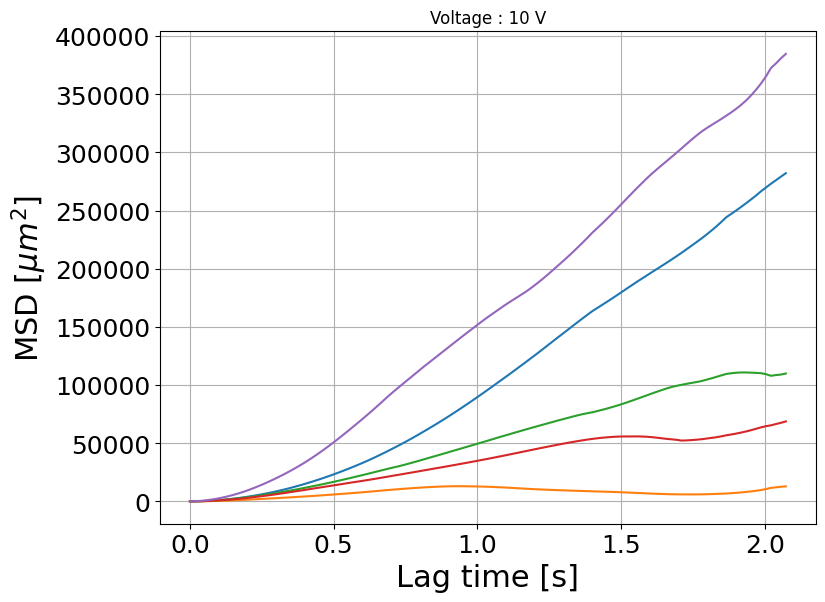

Track 19 for voltage 3 has less than 2 points after the pulse, skipping.
Track 20 for voltage 3 has less than 2 points after the pulse, skipping.
Track 21 for voltage 3 has less than 2 points after the pulse, skipping.
Track 22 for voltage 3 has less than 2 points after the pulse, skipping.
Track 23 for voltage 3 has less than 2 points after the pulse, skipping.
Track 24 for voltage 3 has less than 2 points after the pulse, skipping.
Track 25 for voltage 3 has less than 2 points after the pulse, skipping.
Track 26 for voltage 3 has less than 2 points after the pulse, skipping.


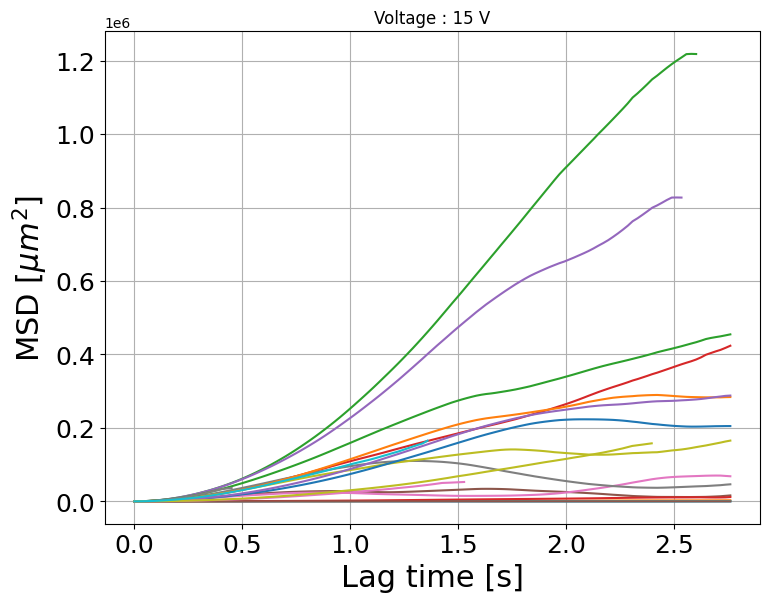

Track 13 for voltage 4 has less than 2 points after the pulse, skipping.
Track 19 for voltage 4 has less than 2 points after the pulse, skipping.
Track 20 for voltage 4 has less than 2 points after the pulse, skipping.
Track 21 for voltage 4 has less than 2 points after the pulse, skipping.
Track 22 for voltage 4 has less than 2 points after the pulse, skipping.
Track 23 for voltage 4 has less than 2 points after the pulse, skipping.
Track 24 for voltage 4 has less than 2 points after the pulse, skipping.
Track 25 for voltage 4 has less than 2 points after the pulse, skipping.
Track 26 for voltage 4 has less than 2 points after the pulse, skipping.
Track 27 for voltage 4 has less than 2 points after the pulse, skipping.
Track 28 for voltage 4 has less than 2 points after the pulse, skipping.


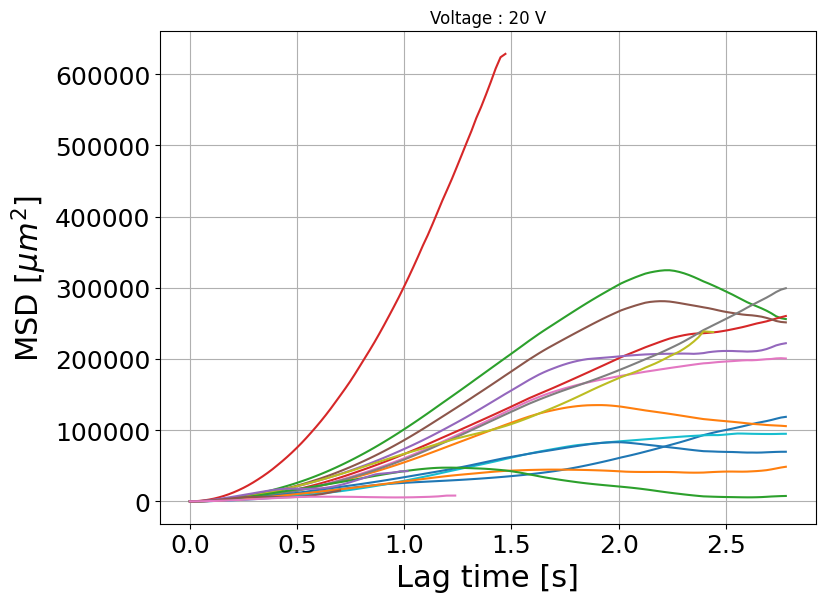

In [55]:
xlabel = r"Lag time [s]"
ylabel = r"MSD [$\mu m^2$]"

time_after_pulse = 3

for i in range(len(data_lists)):
    data_list = data_lists[i]
    
    ax, fig = u.create_figure_and_apply_format((8,6), xlabel=xlabel, ylabel=ylabel)
    
    for j in range(len(data_list)):
        x = data_list[j][1]
        y = data_list[j][2]
        t = data_list[j][0]
        
        mask = (t >= t_pulse) & (t <= t_pulse + time_after_pulse)
        x = x[mask]
        y = y[mask]
        t = t[mask]
        
        if len(x) < 10 : 
            print(f"Track {j+1} for voltage {i} has less than 2 points after the pulse, skipping.")
            continue
        
        msd = MSD(x, y,max_lag=len(t)-1)
        
        lag_times = np.arange(len(msd)) * (t[1] - t[0])  # Assuming uniform time intervals
        
        ax.plot(lag_times, msd, label=f"Track {j+1}")
        
    ax.set_title(f"Voltage : {Vs[i]} V")
        
    # u.set_legend_properties(ax)
    fig.savefig(f"/workspaces/TP3/TP_Dying-cells/Figures/{directories[i]}_msd.pdf", bbox_inches='tight')
    plt.show()